# Description

Runs k-means on the pca version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

2

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=2
env: OPEN_BLAS_NUM_THREADS=2
env: NUMEXPR_NUM_THREADS=2
env: OMP_NUM_THREADS=2


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
np.random.seed(0)

In [6]:
INITIAL_RANDOM_STATE = 10000

## Input data

In [7]:
INPUT_SUBSET = "pca"

In [8]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
DR_OPTIONS = {
    "n_components": 50,
    "svd_solver": "full",
    "random_state": 0,
}

In [10]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/pca/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full.pkl')

'pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full'

## Clustering

In [11]:
from sklearn.cluster import KMeans

In [12]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [13]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 60  # sqrt(3749)
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10

display(CLUSTERING_OPTIONS)

{'K_MIN': 2, 'K_MAX': 60, 'N_REPS_PER_K': 5, 'KMEANS_N_INIT': 10}

In [14]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
        clus = KMeans(
            n_clusters=k,
            n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
            random_state=random_state,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        random_state = random_state + 1
        idx = idx + 1

In [15]:
display(len(CLUSTERERS))

295

In [16]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('KMeans #0', KMeans(n_clusters=2, random_state=10000))

('KMeans #1', KMeans(n_clusters=2, random_state=10001))

In [17]:
clustering_method_name = method_name
display(clustering_method_name)

'KMeans'

## Output directory

In [18]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [19]:
data = pd.read_pickle(input_filepath)

In [20]:
data.shape

(3749, 50)

In [21]:
data.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
100001_raw-Food_weight,-0.547515,-0.007250,0.245361,0.132424,1.201447,-0.113158,0.048859,1.031679,0.711208,0.126100,...,0.113685,-0.109753,0.178202,-0.487868,1.805920,-0.342611,-0.663712,-1.313987,-1.481707,0.396410
100002_raw-Energy,-1.570593,-0.618992,-1.223395,1.627321,-0.563860,0.224922,-1.500327,2.045633,-1.665998,-0.180432,...,0.697880,1.412676,2.103988,0.385625,2.386495,-2.939998,-0.978275,-1.893307,-0.259497,0.423264
100003_raw-Protein,-0.601212,-0.948824,-1.022209,2.438433,-2.062235,0.356202,-1.538038,2.314675,-1.108991,0.318034,...,0.171992,1.351979,0.054404,-0.725132,2.226520,-3.481674,-0.445294,-0.477452,0.237157,1.440867
100004_raw-Fat,-1.648214,-0.342042,-0.270189,1.683268,-1.222401,0.018349,-0.032824,1.671161,-0.908965,0.224100,...,-0.358812,0.696836,1.072624,0.627951,1.802000,0.174704,0.826319,-0.826992,0.596113,0.620050
100005_raw-Carbohydrate,-1.867586,-0.006412,-0.303220,0.770958,-0.116822,0.460946,-2.407732,1.534273,-1.930577,0.064621,...,1.332852,1.978032,2.158456,0.831123,1.093202,-3.539033,-0.831862,-0.842298,-0.723072,0.359438


In [22]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [23]:
from clustering.ensembles.utils import generate_ensemble

In [24]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

  0%|          | 0/295 [00:00<?, ?it/s]

  1%|          | 3/295 [00:00<00:13, 21.15it/s]

  2%|▏         | 6/295 [00:00<00:14, 20.61it/s]

  3%|▎         | 8/295 [00:00<00:15, 18.79it/s]

  3%|▎         | 10/295 [00:00<00:16, 17.64it/s]

  4%|▍         | 12/295 [00:00<00:18, 15.65it/s]

  5%|▍         | 14/295 [00:00<00:19, 14.23it/s]

  5%|▌         | 16/295 [00:01<00:21, 12.83it/s]

  6%|▌         | 18/295 [00:01<00:25, 10.80it/s]

  7%|▋         | 20/295 [00:01<00:27,  9.95it/s]

  7%|▋         | 21/295 [00:01<00:30,  8.86it/s]

  7%|▋         | 22/295 [00:01<00:33,  8.21it/s]

  8%|▊         | 23/295 [00:02<00:35,  7.72it/s]

  8%|▊         | 24/295 [00:02<00:35,  7.67it/s]

  8%|▊         | 25/295 [00:02<00:36,  7.37it/s]

  9%|▉         | 26/295 [00:02<00:39,  6.84it/s]

  9%|▉         | 27/295 [00:02<00:41,  6.49it/s]

  9%|▉         | 28/295 [00:02<00:42,  6.30it/s]

 10%|▉         | 29/295 [00:02<00:42,  6.26it/s]

 10%|█         | 30/295 [00:03<00:45,  5.83it/s]

 11%|█         | 31/295 [00:03<00:47,  5.61it/s]

 11%|█         | 32/295 [00:03<00:48,  5.41it/s]

 11%|█         | 33/295 [00:03<00:52,  4.99it/s]

 12%|█▏        | 34/295 [00:04<00:54,  4.77it/s]

 12%|█▏        | 35/295 [00:04<00:56,  4.63it/s]

 12%|█▏        | 36/295 [00:04<00:56,  4.56it/s]

 13%|█▎        | 37/295 [00:04<01:02,  4.15it/s]

 13%|█▎        | 38/295 [00:05<01:02,  4.11it/s]

 13%|█▎        | 39/295 [00:05<01:01,  4.13it/s]

 14%|█▎        | 40/295 [00:05<00:59,  4.27it/s]

 14%|█▍        | 41/295 [00:05<01:05,  3.90it/s]

 14%|█▍        | 42/295 [00:06<01:06,  3.80it/s]

 15%|█▍        | 43/295 [00:06<01:06,  3.79it/s]

 15%|█▍        | 44/295 [00:06<01:09,  3.61it/s]

 15%|█▌        | 45/295 [00:06<01:08,  3.66it/s]

 16%|█▌        | 46/295 [00:07<01:08,  3.64it/s]

 16%|█▌        | 47/295 [00:07<01:07,  3.70it/s]

 16%|█▋        | 48/295 [00:07<01:11,  3.47it/s]

 17%|█▋        | 49/295 [00:08<01:18,  3.15it/s]

 17%|█▋        | 50/295 [00:08<01:20,  3.05it/s]

 17%|█▋        | 51/295 [00:08<01:19,  3.05it/s]

 18%|█▊        | 52/295 [00:09<01:20,  3.03it/s]

 18%|█▊        | 53/295 [00:09<01:20,  3.00it/s]

 18%|█▊        | 54/295 [00:09<01:23,  2.88it/s]

 19%|█▊        | 55/295 [00:10<01:21,  2.94it/s]

 19%|█▉        | 56/295 [00:10<01:25,  2.79it/s]

 19%|█▉        | 57/295 [00:10<01:26,  2.77it/s]

 20%|█▉        | 58/295 [00:11<01:27,  2.72it/s]

 20%|██        | 59/295 [00:11<01:28,  2.66it/s]

 20%|██        | 60/295 [00:12<01:29,  2.63it/s]

 21%|██        | 61/295 [00:12<01:29,  2.61it/s]

 21%|██        | 62/295 [00:12<01:30,  2.58it/s]

 21%|██▏       | 63/295 [00:13<01:26,  2.69it/s]

 22%|██▏       | 64/295 [00:13<01:22,  2.81it/s]

 22%|██▏       | 65/295 [00:13<01:22,  2.80it/s]

 22%|██▏       | 66/295 [00:14<01:23,  2.73it/s]

 23%|██▎       | 67/295 [00:14<01:23,  2.74it/s]

 23%|██▎       | 68/295 [00:15<01:25,  2.66it/s]

 23%|██▎       | 69/295 [00:15<01:28,  2.56it/s]

 24%|██▎       | 70/295 [00:15<01:27,  2.56it/s]

 24%|██▍       | 71/295 [00:16<01:24,  2.66it/s]

 24%|██▍       | 72/295 [00:16<01:21,  2.73it/s]

 25%|██▍       | 73/295 [00:16<01:17,  2.85it/s]

 25%|██▌       | 74/295 [00:17<01:20,  2.75it/s]

 25%|██▌       | 75/295 [00:17<01:19,  2.76it/s]

 26%|██▌       | 76/295 [00:18<01:19,  2.74it/s]

 26%|██▌       | 77/295 [00:18<01:24,  2.59it/s]

 26%|██▋       | 78/295 [00:18<01:23,  2.61it/s]

 27%|██▋       | 79/295 [00:19<01:23,  2.58it/s]

 27%|██▋       | 80/295 [00:19<01:21,  2.63it/s]

 27%|██▋       | 81/295 [00:20<01:22,  2.58it/s]

 28%|██▊       | 82/295 [00:20<01:24,  2.53it/s]

 28%|██▊       | 83/295 [00:20<01:23,  2.55it/s]

 28%|██▊       | 84/295 [00:21<01:27,  2.40it/s]

 29%|██▉       | 85/295 [00:21<01:23,  2.52it/s]

 29%|██▉       | 86/295 [00:22<01:25,  2.44it/s]

 29%|██▉       | 87/295 [00:22<01:26,  2.39it/s]

 30%|██▉       | 88/295 [00:22<01:23,  2.47it/s]

 30%|███       | 89/295 [00:23<01:24,  2.45it/s]

 31%|███       | 90/295 [00:23<01:22,  2.50it/s]

 31%|███       | 91/295 [00:24<01:20,  2.55it/s]

 31%|███       | 92/295 [00:24<01:22,  2.46it/s]

 32%|███▏      | 93/295 [00:24<01:20,  2.50it/s]

 32%|███▏      | 94/295 [00:25<01:21,  2.47it/s]

 32%|███▏      | 95/295 [00:25<01:22,  2.42it/s]

 33%|███▎      | 96/295 [00:26<01:23,  2.37it/s]

 33%|███▎      | 97/295 [00:26<01:25,  2.33it/s]

 33%|███▎      | 98/295 [00:27<01:24,  2.32it/s]

 34%|███▎      | 99/295 [00:27<01:20,  2.44it/s]

 34%|███▍      | 100/295 [00:27<01:22,  2.36it/s]

 34%|███▍      | 101/295 [00:28<01:25,  2.26it/s]

 35%|███▍      | 102/295 [00:28<01:25,  2.26it/s]

 35%|███▍      | 103/295 [00:29<01:24,  2.27it/s]

 35%|███▌      | 104/295 [00:29<01:26,  2.20it/s]

 36%|███▌      | 105/295 [00:30<01:28,  2.14it/s]

 36%|███▌      | 106/295 [00:30<01:26,  2.17it/s]

 36%|███▋      | 107/295 [00:31<01:29,  2.11it/s]

 37%|███▋      | 108/295 [00:31<01:28,  2.10it/s]

 37%|███▋      | 109/295 [00:32<01:28,  2.10it/s]

 37%|███▋      | 110/295 [00:32<01:28,  2.09it/s]

 38%|███▊      | 111/295 [00:33<01:26,  2.12it/s]

 38%|███▊      | 112/295 [00:33<01:26,  2.10it/s]

 38%|███▊      | 113/295 [00:33<01:24,  2.16it/s]

 39%|███▊      | 114/295 [00:34<01:26,  2.09it/s]

 39%|███▉      | 115/295 [00:34<01:23,  2.17it/s]

 39%|███▉      | 116/295 [00:35<01:24,  2.12it/s]

 40%|███▉      | 117/295 [00:35<01:27,  2.04it/s]

 40%|████      | 118/295 [00:36<01:30,  1.96it/s]

 40%|████      | 119/295 [00:37<01:30,  1.95it/s]

 41%|████      | 120/295 [00:37<01:27,  2.00it/s]

 41%|████      | 121/295 [00:38<01:28,  1.97it/s]

 41%|████▏     | 122/295 [00:38<01:29,  1.94it/s]

 42%|████▏     | 123/295 [00:39<01:26,  1.98it/s]

 42%|████▏     | 124/295 [00:39<01:27,  1.96it/s]

 42%|████▏     | 125/295 [00:40<01:27,  1.95it/s]

 43%|████▎     | 126/295 [00:40<01:29,  1.89it/s]

 43%|████▎     | 127/295 [00:41<01:26,  1.93it/s]

 43%|████▎     | 128/295 [00:41<01:27,  1.90it/s]

 44%|████▎     | 129/295 [00:42<01:26,  1.92it/s]

 44%|████▍     | 130/295 [00:42<01:29,  1.84it/s]

 44%|████▍     | 131/295 [00:43<01:30,  1.82it/s]

 45%|████▍     | 132/295 [00:43<01:33,  1.75it/s]

 45%|████▌     | 133/295 [00:44<01:30,  1.79it/s]

 45%|████▌     | 134/295 [00:45<01:30,  1.77it/s]

 46%|████▌     | 135/295 [00:45<01:29,  1.80it/s]

 46%|████▌     | 136/295 [00:46<01:27,  1.82it/s]

 46%|████▋     | 137/295 [00:46<01:27,  1.80it/s]

 47%|████▋     | 138/295 [00:47<01:29,  1.76it/s]

 47%|████▋     | 139/295 [00:47<01:26,  1.79it/s]

 47%|████▋     | 140/295 [00:48<01:30,  1.71it/s]

 48%|████▊     | 141/295 [00:49<01:32,  1.66it/s]

 48%|████▊     | 142/295 [00:49<01:31,  1.66it/s]

 48%|████▊     | 143/295 [00:50<01:32,  1.65it/s]

 49%|████▉     | 144/295 [00:50<01:28,  1.71it/s]

 49%|████▉     | 145/295 [00:51<01:26,  1.73it/s]

 49%|████▉     | 146/295 [00:52<01:25,  1.74it/s]

 50%|████▉     | 147/295 [00:52<01:28,  1.68it/s]

 50%|█████     | 148/295 [00:53<01:25,  1.71it/s]

 51%|█████     | 149/295 [00:53<01:23,  1.75it/s]

 51%|█████     | 150/295 [00:54<01:26,  1.68it/s]

 51%|█████     | 151/295 [00:55<01:26,  1.66it/s]

 52%|█████▏    | 152/295 [00:55<01:27,  1.63it/s]

 52%|█████▏    | 153/295 [00:56<01:30,  1.57it/s]

 52%|█████▏    | 154/295 [00:56<01:29,  1.58it/s]

 53%|█████▎    | 155/295 [00:57<01:29,  1.57it/s]

 53%|█████▎    | 156/295 [00:58<01:25,  1.62it/s]

 53%|█████▎    | 157/295 [00:58<01:23,  1.66it/s]

 54%|█████▎    | 158/295 [00:59<01:20,  1.69it/s]

 54%|█████▍    | 159/295 [01:00<01:24,  1.61it/s]

 54%|█████▍    | 160/295 [01:00<01:24,  1.60it/s]

 55%|█████▍    | 161/295 [01:01<01:21,  1.64it/s]

 55%|█████▍    | 162/295 [01:01<01:23,  1.59it/s]

 55%|█████▌    | 163/295 [01:02<01:22,  1.59it/s]

 56%|█████▌    | 164/295 [01:03<01:24,  1.55it/s]

 56%|█████▌    | 165/295 [01:03<01:24,  1.54it/s]

 56%|█████▋    | 166/295 [01:04<01:27,  1.48it/s]

 57%|█████▋    | 167/295 [01:05<01:29,  1.44it/s]

 57%|█████▋    | 168/295 [01:06<01:29,  1.41it/s]

 57%|█████▋    | 169/295 [01:06<01:27,  1.43it/s]

 58%|█████▊    | 170/295 [01:07<01:24,  1.47it/s]

 58%|█████▊    | 171/295 [01:08<01:23,  1.48it/s]

 58%|█████▊    | 172/295 [01:08<01:24,  1.46it/s]

 59%|█████▊    | 173/295 [01:09<01:21,  1.50it/s]

 59%|█████▉    | 174/295 [01:10<01:21,  1.48it/s]

 59%|█████▉    | 175/295 [01:10<01:18,  1.53it/s]

 60%|█████▉    | 176/295 [01:11<01:17,  1.53it/s]

 60%|██████    | 177/295 [01:11<01:16,  1.55it/s]

 60%|██████    | 178/295 [01:12<01:15,  1.55it/s]

 61%|██████    | 179/295 [01:13<01:14,  1.55it/s]

 61%|██████    | 180/295 [01:13<01:16,  1.51it/s]

 61%|██████▏   | 181/295 [01:14<01:15,  1.50it/s]

 62%|██████▏   | 182/295 [01:15<01:18,  1.44it/s]

 62%|██████▏   | 183/295 [01:16<01:18,  1.44it/s]

 62%|██████▏   | 184/295 [01:16<01:16,  1.45it/s]

 63%|██████▎   | 185/295 [01:17<01:15,  1.45it/s]

 63%|██████▎   | 186/295 [01:18<01:18,  1.38it/s]

 63%|██████▎   | 187/295 [01:19<01:18,  1.37it/s]

 64%|██████▎   | 188/295 [01:19<01:16,  1.40it/s]

 64%|██████▍   | 189/295 [01:20<01:15,  1.41it/s]

 64%|██████▍   | 190/295 [01:21<01:13,  1.42it/s]

 65%|██████▍   | 191/295 [01:21<01:14,  1.39it/s]

 65%|██████▌   | 192/295 [01:22<01:15,  1.37it/s]

 65%|██████▌   | 193/295 [01:23<01:12,  1.40it/s]

 66%|██████▌   | 194/295 [01:23<01:10,  1.43it/s]

 66%|██████▌   | 195/295 [01:24<01:11,  1.40it/s]

 66%|██████▋   | 196/295 [01:25<01:11,  1.38it/s]

 67%|██████▋   | 197/295 [01:26<01:11,  1.37it/s]

 67%|██████▋   | 198/295 [01:26<01:10,  1.37it/s]

 67%|██████▋   | 199/295 [01:27<01:11,  1.35it/s]

 68%|██████▊   | 200/295 [01:28<01:10,  1.35it/s]

 68%|██████▊   | 201/295 [01:29<01:09,  1.35it/s]

 68%|██████▊   | 202/295 [01:29<01:08,  1.36it/s]

 69%|██████▉   | 203/295 [01:30<01:07,  1.36it/s]

 69%|██████▉   | 204/295 [01:31<01:06,  1.37it/s]

 69%|██████▉   | 205/295 [01:32<01:07,  1.34it/s]

 70%|██████▉   | 206/295 [01:32<01:07,  1.31it/s]

 70%|███████   | 207/295 [01:33<01:07,  1.30it/s]

 71%|███████   | 208/295 [01:34<01:06,  1.31it/s]

 71%|███████   | 209/295 [01:35<01:04,  1.34it/s]

 71%|███████   | 210/295 [01:35<01:02,  1.35it/s]

 72%|███████▏  | 211/295 [01:36<01:04,  1.31it/s]

 72%|███████▏  | 212/295 [01:37<01:02,  1.32it/s]

 72%|███████▏  | 213/295 [01:38<01:03,  1.30it/s]

 73%|███████▎  | 214/295 [01:39<01:02,  1.30it/s]

 73%|███████▎  | 215/295 [01:39<01:02,  1.29it/s]

 73%|███████▎  | 216/295 [01:40<00:59,  1.32it/s]

 74%|███████▎  | 217/295 [01:41<00:59,  1.31it/s]

 74%|███████▍  | 218/295 [01:42<00:59,  1.29it/s]

 74%|███████▍  | 219/295 [01:42<00:58,  1.30it/s]

 75%|███████▍  | 220/295 [01:43<00:56,  1.32it/s]

 75%|███████▍  | 221/295 [01:44<00:54,  1.35it/s]

 75%|███████▌  | 222/295 [01:45<00:55,  1.33it/s]

 76%|███████▌  | 223/295 [01:45<00:54,  1.31it/s]

 76%|███████▌  | 224/295 [01:46<00:54,  1.31it/s]

 76%|███████▋  | 225/295 [01:47<00:54,  1.29it/s]

 77%|███████▋  | 226/295 [01:48<00:53,  1.29it/s]

 77%|███████▋  | 227/295 [01:48<00:52,  1.29it/s]

 77%|███████▋  | 228/295 [01:49<00:55,  1.22it/s]

 78%|███████▊  | 229/295 [01:50<00:53,  1.24it/s]

 78%|███████▊  | 230/295 [01:51<00:51,  1.25it/s]

 78%|███████▊  | 231/295 [01:52<00:52,  1.22it/s]

 79%|███████▊  | 232/295 [01:53<00:49,  1.27it/s]

 79%|███████▉  | 233/295 [01:53<00:49,  1.25it/s]

 79%|███████▉  | 234/295 [01:54<00:48,  1.25it/s]

 80%|███████▉  | 235/295 [01:55<00:46,  1.28it/s]

 80%|████████  | 236/295 [01:56<00:46,  1.26it/s]

 80%|████████  | 237/295 [01:57<00:47,  1.23it/s]

 81%|████████  | 238/295 [01:57<00:46,  1.21it/s]

 81%|████████  | 239/295 [01:58<00:46,  1.21it/s]

 81%|████████▏ | 240/295 [01:59<00:43,  1.26it/s]

 82%|████████▏ | 241/295 [02:00<00:45,  1.19it/s]

 82%|████████▏ | 242/295 [02:01<00:44,  1.20it/s]

 82%|████████▏ | 243/295 [02:02<00:42,  1.22it/s]

 83%|████████▎ | 244/295 [02:02<00:42,  1.20it/s]

 83%|████████▎ | 245/295 [02:03<00:42,  1.17it/s]

 83%|████████▎ | 246/295 [02:04<00:42,  1.15it/s]

 84%|████████▎ | 247/295 [02:05<00:41,  1.16it/s]

 84%|████████▍ | 248/295 [02:06<00:40,  1.17it/s]

 84%|████████▍ | 249/295 [02:07<00:39,  1.18it/s]

 85%|████████▍ | 250/295 [02:08<00:38,  1.16it/s]

 85%|████████▌ | 251/295 [02:09<00:39,  1.11it/s]

 85%|████████▌ | 252/295 [02:10<00:39,  1.09it/s]

 86%|████████▌ | 253/295 [02:10<00:37,  1.12it/s]

 86%|████████▌ | 254/295 [02:11<00:37,  1.09it/s]

 86%|████████▋ | 255/295 [02:12<00:35,  1.12it/s]

 87%|████████▋ | 256/295 [02:13<00:34,  1.12it/s]

 87%|████████▋ | 257/295 [02:14<00:33,  1.13it/s]

 87%|████████▋ | 258/295 [02:15<00:33,  1.11it/s]

 88%|████████▊ | 259/295 [02:16<00:32,  1.12it/s]

 88%|████████▊ | 260/295 [02:17<00:31,  1.12it/s]

 88%|████████▊ | 261/295 [02:18<00:30,  1.11it/s]

 89%|████████▉ | 262/295 [02:18<00:28,  1.14it/s]

 89%|████████▉ | 263/295 [02:19<00:28,  1.12it/s]

 89%|████████▉ | 264/295 [02:20<00:27,  1.14it/s]

 90%|████████▉ | 265/295 [02:21<00:25,  1.15it/s]

 90%|█████████ | 266/295 [02:22<00:25,  1.12it/s]

 91%|█████████ | 267/295 [02:23<00:25,  1.11it/s]

 91%|█████████ | 268/295 [02:24<00:24,  1.12it/s]

 91%|█████████ | 269/295 [02:25<00:23,  1.12it/s]

 92%|█████████▏| 270/295 [02:26<00:22,  1.11it/s]

 92%|█████████▏| 271/295 [02:27<00:22,  1.04it/s]

 92%|█████████▏| 272/295 [02:28<00:21,  1.05it/s]

 93%|█████████▎| 273/295 [02:29<00:21,  1.04it/s]

 93%|█████████▎| 274/295 [02:30<00:20,  1.04it/s]

 93%|█████████▎| 275/295 [02:30<00:18,  1.08it/s]

 94%|█████████▎| 276/295 [02:31<00:17,  1.07it/s]

 94%|█████████▍| 277/295 [02:32<00:16,  1.07it/s]

 94%|█████████▍| 278/295 [02:33<00:15,  1.10it/s]

 95%|█████████▍| 279/295 [02:34<00:15,  1.06it/s]

 95%|█████████▍| 280/295 [02:35<00:13,  1.08it/s]

 95%|█████████▌| 281/295 [02:36<00:13,  1.08it/s]

 96%|█████████▌| 282/295 [02:37<00:11,  1.08it/s]

 96%|█████████▌| 283/295 [02:38<00:11,  1.07it/s]

 96%|█████████▋| 284/295 [02:39<00:10,  1.08it/s]

 97%|█████████▋| 285/295 [02:40<00:09,  1.07it/s]

 97%|█████████▋| 286/295 [02:41<00:08,  1.04it/s]

 97%|█████████▋| 287/295 [02:42<00:07,  1.05it/s]

 98%|█████████▊| 288/295 [02:43<00:06,  1.06it/s]

 98%|█████████▊| 289/295 [02:44<00:05,  1.07it/s]

 98%|█████████▊| 290/295 [02:44<00:04,  1.08it/s]

 99%|█████████▊| 291/295 [02:45<00:03,  1.07it/s]

 99%|█████████▉| 292/295 [02:46<00:02,  1.04it/s]

 99%|█████████▉| 293/295 [02:47<00:01,  1.03it/s]

100%|█████████▉| 294/295 [02:48<00:00,  1.03it/s]

100%|██████████| 295/295 [02:49<00:00,  1.01it/s]

100%|██████████| 295/295 [02:49<00:00,  1.74it/s]

In [25]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(295, 3)

In [26]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
KMeans #0,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
KMeans #1,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
KMeans #2,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
KMeans #3,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
KMeans #4,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2


In [27]:
ensemble["n_clusters"].value_counts().head()

60    5
16    5
28    5
27    5
26    5
Name: n_clusters, dtype: int64

In [28]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    295.000000
mean      31.000000
std       17.058323
min        2.000000
25%       16.000000
50%       31.000000
75%       46.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [29]:
assert ensemble_stats["min"] > 1

In [30]:
assert not ensemble["n_clusters"].isna().any()

In [31]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [32]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [33]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Add clustering quality measures

In [34]:
from sklearn.metrics import calinski_harabasz_score

In [35]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [36]:
ensemble.shape

(295, 4)

In [37]:
ensemble.head()

,clusterer_params,partition,n_clusters,ch_score
clusterer_id,,,,
KMeans #0,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,921.216986
KMeans #1,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,921.216986
KMeans #2,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,921.216986
KMeans #3,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,921.216986
KMeans #4,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,921.216986


## Save

In [38]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/KMeans-KMEANS_N_INIT_10-K_MAX_60-K_MIN_2-N_REPS_PER_K_5.pkl')

In [39]:
ensemble.to_pickle(output_filename)

# Cluster quality

In [40]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,ch_score
n_clusters,
2,921.216986
3,630.844590
4,547.403175
5,470.068428
6,420.753349
7,387.362291
8,355.274672
9,338.350292
10,322.694552


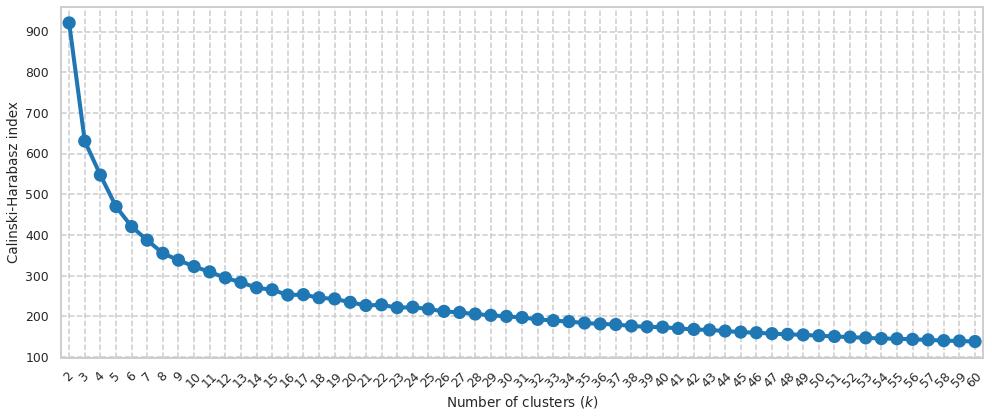

In [41]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [42]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [43]:
parts.head()

n_clusters
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
4    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
5    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
dtype: object

In [44]:
assert np.all(
    [
        parts.loc[k].shape == (CLUSTERING_OPTIONS["N_REPS_PER_K"], data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [45]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [46]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [47]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

2     1.000000
4     0.998132
3     0.993598
5     0.983751
6     0.969448
7     0.963893
9     0.937197
10    0.923767
11    0.913798
8     0.854730
13    0.842554
16    0.828863
14    0.653496
12    0.607263
15    0.510900
Name: k, dtype: float64

In [48]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [49]:
parts_ari_df.shape

(59, 10)

In [50]:
assert (
    int(
        (CLUSTERING_OPTIONS["N_REPS_PER_K"] * (CLUSTERING_OPTIONS["N_REPS_PER_K"] - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [51]:
parts_ari_df.head()

,0,1,2,3,4,5,6,7,8,9
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
3,0.989330,1.000000,1.000000,0.989330,0.989330,0.98933,1.000000,1.000000,0.989330,0.989330
4,1.000000,0.997001,1.000000,0.996829,0.997001,1.00000,0.996829,0.997001,0.999826,0.996829
5,0.999967,0.965204,0.999967,0.988705,0.965179,1.00000,0.988698,0.965179,0.975909,0.988698
6,0.928658,0.926795,0.932134,0.932060,0.997446,0.99461,0.994498,0.994140,0.994251,0.999888


## Save

In [52]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/KMeans-stability-KMEANS_N_INIT_10-K_MAX_60-K_MIN_2-N_REPS_PER_K_5.pkl')

In [53]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [54]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [55]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [56]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,1.0
1,2,1,1.0
2,2,2,1.0
3,2,3,1.0
4,2,4,1.0


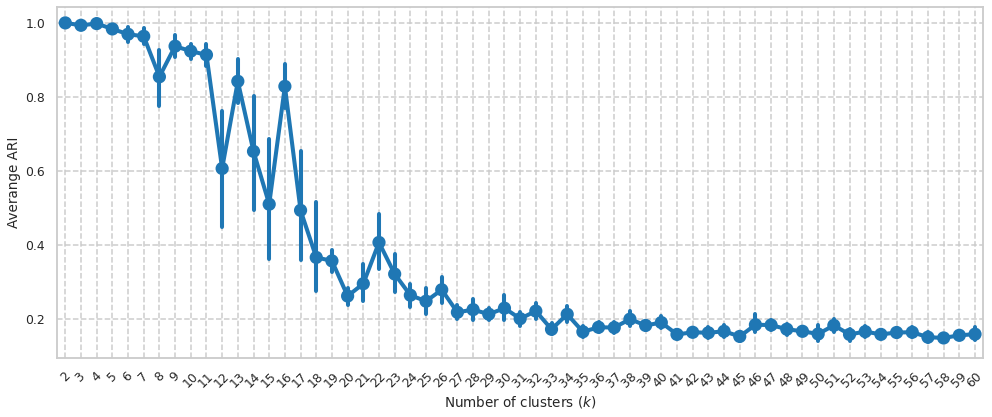

In [57]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()